In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, mean_squared_error, roc_curve, auc, average_precision_score, RocCurveDisplay
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import shap

# Load the dataset
df = pd.read_csv('Dataset/diabetes.csv')

## Load dataset information

In [5]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Data type & Null count

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Display the dataFrame in Statistics form

In [9]:
stat_df = df.describe().style 
stat_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Show histogram of dataset


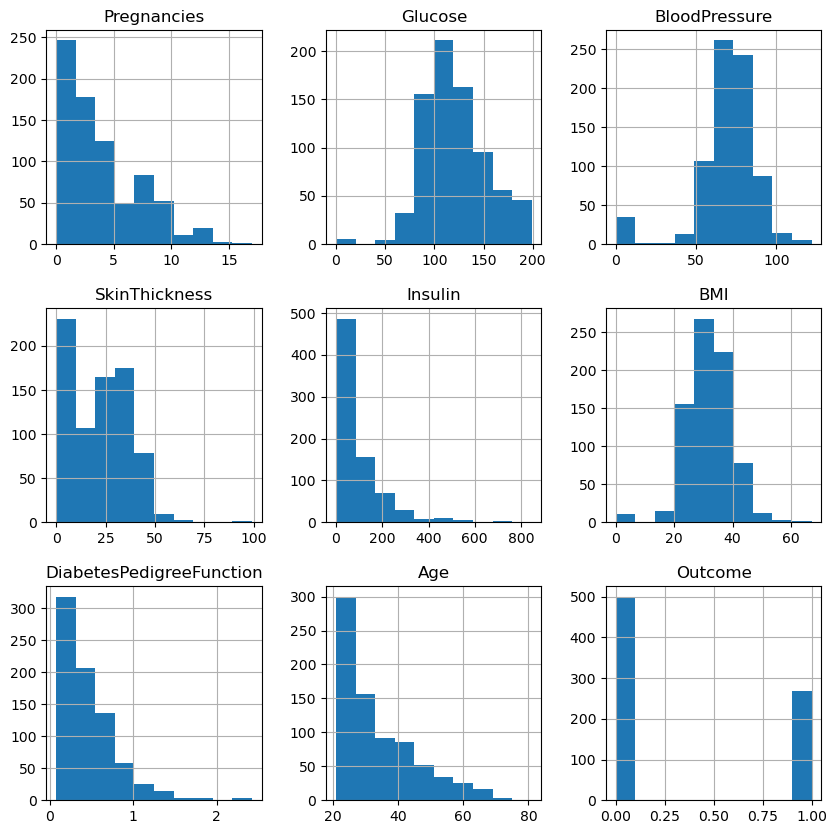

In [11]:
df.hist(figsize = (10,10))
plt.show()

# Define Features && last column "Outcome" as Class

In [13]:
X = df.iloc[:, :-1]  # Features = "Pregnancies" , "Glucose", "BloodPressure", "SkinThickness", "Inssulin", "BMI", "DiabetesPedigreeFunction", "Age"
y = df.iloc[:, -1]   # Class = "Outcome"

## Split data (80:20)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGB Classifier (Training & Testing)

In [17]:
xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.01, max_depth=2) 
# Train the model
xgb_model.fit(X_train, y_train)
# Make predictions
xgb_y_pred = xgb_model.predict(X_test)
train_accuracy = xgb_model.score(X_train, y_train)
val_accuracy = xgb_model.score(X_test, y_test)
print(classification_report(y_test,xgb_y_pred))
print(confusion_matrix(y_test,xgb_y_pred))
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        99
           1       0.70      0.64      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.75       154
weighted avg       0.77      0.77      0.77       154

[[84 15]
 [20 35]]
Training Accuracy: 0.8110749185667753
Validation Accuracy: 0.7727272727272727


## XGB Classifier (Find Best Hyperparameter)

In [19]:
#XGB (Hyperparameter tunning)
#parameters = {'n_estimators':np.arange(20,401),
#              'max_depth':np.arange(3,12),
#               'learning_rate': np.arange(0.01,1) }

#xgb_model_best = RandomizedSearchCV(XGBClassifier(), parameters, n_iter=20)
#xgb_model_best.fit(X_train, y_train)

#print(xgb_model_best.best_score_)
#print(xgb_model_best.best_params_)

## XGB Classifier (Apply on Original Dataset)

In [21]:
xgb_test = pd.read_csv('Dataset/diabetes.csv')
xgb_test = xgb_test.drop(columns=['Outcome'])
y_pred = xgb_model.predict(xgb_test)
xgb_test['Outcome'] = y_pred
# Export Predicted value to a new .csv file
xgb_test.to_csv('XGB_prediction.csv', index=False)


## Orginal Result vs Prediction (XGB) 
## Find Differents on column "Outcome"

In [23]:
# Read CSV files
df1 = pd.read_csv('Dataset/diabetes.csv')
df2 = pd.read_csv('XGB_prediction.csv')
# Compare dataframes
diff = df1.compare(df2)
# Print the differences (151 predict error, 80.36% Acc)
print("Differences between Original Result and Prediction:")
print(diff)

Differences between Original Result and Prediction:
    Outcome      
       self other
6       1.0   0.0
9       1.0   0.0
15      1.0   0.0
17      1.0   0.0
23      1.0   0.0
..      ...   ...
731     1.0   0.0
739     1.0   0.0
744     0.0   1.0
750     1.0   0.0
756     0.0   1.0

[151 rows x 2 columns]


## Random Forest (Training & Testing)

In [25]:
rf_model = RandomForestClassifier(n_estimators=159, max_depth=3, criterion = 'gini')
# Train the model
rf_model.fit(X_train, y_train)
# Make predictions
rf_y_pred = rf_model.predict(X_test)
train_accuracy = rf_model.score(X_train, y_train)
val_accuracy = rf_model.score(X_test, y_test)
print(classification_report(y_test,rf_y_pred))
print(confusion_matrix(y_test,rf_y_pred))
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

              precision    recall  f1-score   support

           0       0.80      0.91      0.85        99
           1       0.78      0.58      0.67        55

    accuracy                           0.79       154
   macro avg       0.79      0.75      0.76       154
weighted avg       0.79      0.79      0.78       154

[[90  9]
 [23 32]]
Training Accuracy: 0.7980456026058632
Validation Accuracy: 0.7922077922077922


## Random Forest (Find Best Hyperparameter)

In [27]:
#Random Forest (Hyperparameter tunning)
#parameters = {'n_estimators':np.arange(20,200),
#              'max_depth':np.arange(3,12),
#               'criterion':['gini','entropy'] }

#rf_model_best = RandomizedSearchCV(RandomForestClassifier(), parameters, n_iter=20)
#rf_model_best.fit(X_train, y_train)

#print(rf_model_best.best_score_)
#print(rf_model_best.best_params_)

## Random Forest (Apply on Original Dataset)

In [29]:
rf_test = pd.read_csv('Dataset/diabetes.csv')

rf_test = rf_test.drop(columns=['Outcome'])

y_pred = rf_model.predict(rf_test)


#rf_test['Outcome'] = predictions #Sample
rf_test['Outcome'] = y_pred


# Export Predicted value to a new .csv file
rf_test.to_csv('RF_prediction.csv', index=False)


## Orginal Result vs Prediction (Random Forest)## Find Differents on column "Outcome"

In [31]:
# Read CSV files
df1 = pd.read_csv('Dataset/diabetes.csv')
df2 = pd.read_csv('RF_prediction.csv')

# Compare dataframes
diff = df1.compare(df2)

# Print the differences (161 predict error, 79.06% Acc)
print("Differences between Original Result and Prediction:")
print(diff)

Differences between Original Result and Prediction:
    Outcome      
       self other
6       1.0   0.0
9       1.0   0.0
15      1.0   0.0
16      1.0   0.0
17      1.0   0.0
..      ...   ...
749     1.0   0.0
750     1.0   0.0
756     0.0   1.0
757     1.0   0.0
766     1.0   0.0

[156 rows x 2 columns]


## Logistic Regression (Training & Testing) 

In [33]:
lr_model = LogisticRegression(max_iter=1000, penalty = 'l1', solver = 'liblinear')
# Train the model
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
train_accuracy = lr_model.score(X_train, y_train)
val_accuracy = lr_model.score(X_test, y_test)
print(classification_report(y_test,lr_y_pred))
print(confusion_matrix(y_test,lr_y_pred))
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        99
           1       0.65      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154

[[80 19]
 [19 36]]
Training Accuracy: 0.7703583061889251
Validation Accuracy: 0.7532467532467533


## Logistic Regression (Find Best Hyperparameter)

In [35]:
#Logistic Regression (Hyperparameter tunning)

#parameters = { 'penalty': ['None', 'l1', 'l2', 'elasticnet'],
#               'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] }

#lr_model_best = GridSearchCV(LogisticRegression(max_iter=1000), parameters, n_jobs=-1)
#lr_model_best.fit(X_train, y_train)

#print(lr_model_best.best_score_)
#print(lr_model_best.best_params_)


## Logistic Regression (Apply on Dataset) 

In [37]:
lr_test = pd.read_csv('Dataset/diabetes.csv')
lr_test = lr_test.drop(columns=['Outcome'])
y_pred = lr_model.predict(lr_test)
lr_test['Outcome'] = y_pred
# Export Predicted value to a new .csv file
lr_test.to_csv('LR_prediction.csv', index=False)

## Orginal Result vs Prediction (Logistic Regression)
## Find Differents on column "Outcome"

In [39]:
# Read CSV files
df1 = pd.read_csv('Dataset/diabetes.csv')
df2 = pd.read_csv('LR_prediction.csv')

# Compare dataframes
diff = df1.compare(df2)

# Print the differences (179 predict error, 76.723% Acc)
print("Differences between Original Result and Prediction:")
print(diff)

Differences between Original Result and Prediction:
    Outcome      
       self other
6       1.0   0.0
7       0.0   1.0
9       1.0   0.0
12      0.0   1.0
15      1.0   0.0
..      ...   ...
744     0.0   1.0
750     1.0   0.0
755     1.0   0.0
757     1.0   0.0
766     1.0   0.0

[179 rows x 2 columns]


## AdaBoost (Training & Testing) 

In [41]:
ada_model = AdaBoostClassifier(n_estimators=50, algorithm='SAMME')
# Train the model
ada_model.fit(X_train, y_train)
# Make predictions
ada_y_pred = ada_model.predict(X_test)
train_accuracy = ada_model.score(X_train, y_train)
val_accuracy = ada_model.score(X_test, y_test)
print(classification_report(y_test,ada_y_pred))
print(confusion_matrix(y_test,ada_y_pred))
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)


              precision    recall  f1-score   support

           0       0.84      0.81      0.82        99
           1       0.68      0.73      0.70        55

    accuracy                           0.78       154
   macro avg       0.76      0.77      0.76       154
weighted avg       0.78      0.78      0.78       154

[[80 19]
 [15 40]]
Training Accuracy: 0.8029315960912052
Validation Accuracy: 0.7792207792207793


## AdaBoost (Find Best Hyperparameter)

In [43]:
#Adaboost (Hyperparameter tunning)
#parameters = {'n_estimators':np.arange(50,200),
#              'learning_rate':np.arange(0.01,1),
#               'algorithm' :['SAMME']}

#ada_model_best = RandomizedSearchCV(AdaBoostClassifier(), parameters, n_iter=20)
#ada_model_best.fit(X_train, y_train)

#print(ada_model_best.best_score_)
#print(ada_model_best.best_params_)

## AdaBoost (Apply on Dataset) 

In [45]:
ada_test = pd.read_csv('Dataset/diabetes.csv')
ada_test = ada_test.drop(columns=['Outcome'])
y_pred = ada_model.predict(ada_test)
ada_test['Outcome'] = y_pred
# Export Predicted value to a new .csv file
ada_test.to_csv('ADA_prediction.csv', index=False)


## Orginal Result vs Prediction (AdaBoost)
## Find Differents on column "Outcome"

In [47]:
# Read CSV files
df1 = pd.read_csv('Dataset/diabetes.csv')
df2 = pd.read_csv('ADA_prediction.csv')

# Compare dataframes
diff = df1.compare(df2)

# Print the differences (155 predict error, 79.84% Acc)
print("Differences between Original Result and Prediction:")
print(diff)

Differences between Original Result and Prediction:
    Outcome      
       self other
6       1.0   0.0
9       1.0   0.0
15      1.0   0.0
17      1.0   0.0
19      1.0   0.0
..      ...   ...
731     1.0   0.0
739     1.0   0.0
744     0.0   1.0
756     0.0   1.0
757     1.0   0.0

[155 rows x 2 columns]


### Decision Tree (Training and Testing) #Overfitting if default max_depth)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        99
           1       0.68      0.62      0.65        55

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154

[[83 16]
 [21 34]]
Training Accuracy: 0.7768729641693811
Validation Accuracy: 0.7597402597402597


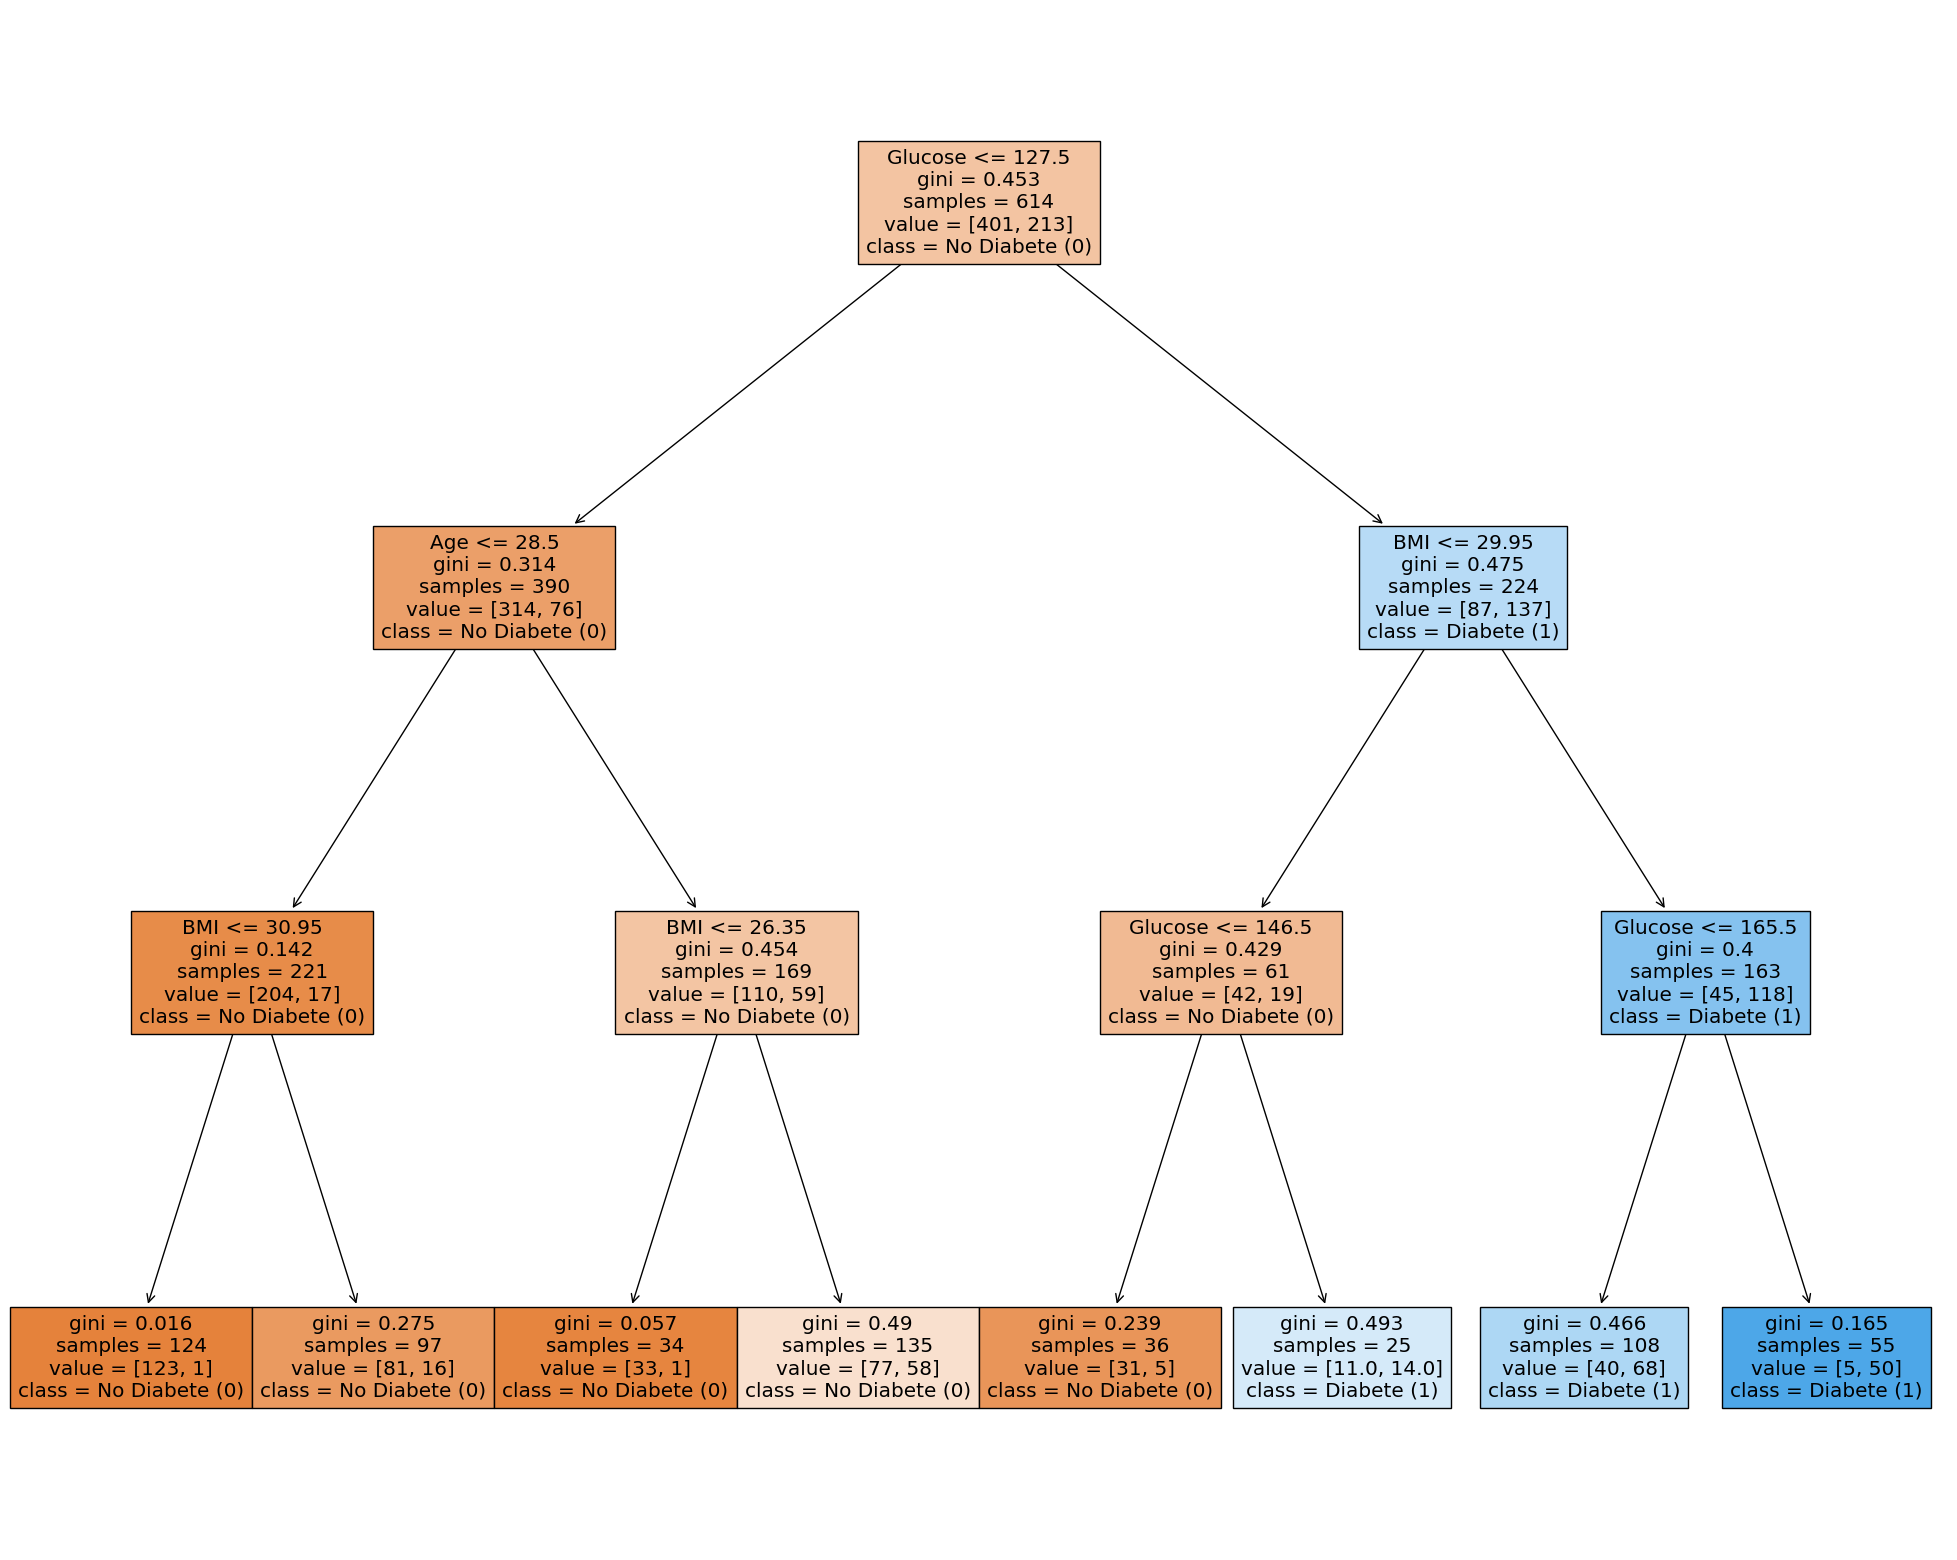

In [49]:
dt_model = DecisionTreeClassifier(max_depth=3)
# Train the model
dt_model.fit(X_train, y_train)
# Make predictions
dt_y_pred = dt_model.predict(X_test)
train_accuracy = dt_model.score(X_train, y_train)
val_accuracy = dt_model.score(X_test, y_test)
print(classification_report(y_test,dt_y_pred))
print(confusion_matrix(y_test,dt_y_pred))
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

from sklearn import tree
fig = plt.figure(figsize=(25,20))
treePlot = tree.plot_tree(dt_model, feature_names=X.columns, class_names=['No Diabete (0)', "Diabete (1)"], filled=True)

## Decision Tree (Find Best Hyperparameter)

In [51]:
#Decision Tree (Hyperparameter tunning)
#parameters = {'criterion':['gini','entropy'],
#              'max_depth':np.arange(3,12),
#              'max_leaf_nodes':np.arange(3,21)}
#
#dt_model_best = RandomizedSearchCV(DecisionTreeClassifier(), parameters, n_iter=20)
#dt_model_best.fit(X_train, y_train)

#print(dt_model_best.best_score_)
#print(dt_model_best.best_params_)


## Decision Tree (Apply on Dataset)

In [53]:
dt_test = pd.read_csv('Dataset/diabetes.csv')

dt_test = dt_test.drop(columns=['Outcome'])

y_pred = dt_model.predict(dt_test)

dt_test['Outcome'] = y_pred

# Export Predicted value to a new .csv file
dt_test.to_csv('DT_prediction.csv', index=False)


## Orginal Result vs Prediction (Decision Tree)
## Find Differents on column "Outcome"

In [55]:
# Read CSV files
df1 = pd.read_csv('Dataset/diabetes.csv')
df2 = pd.read_csv('DT_prediction.csv')

# Compare dataframes
diff = df1.compare(df2)

# Print the differences (174 predict error, 77.373212% Acc)
print("Differences between Original Result and Prediction:")
print(diff)

Differences between Original Result and Prediction:
    Outcome      
       self other
6       1.0   0.0
9       1.0   0.0
15      1.0   0.0
16      1.0   0.0
17      1.0   0.0
..      ...   ...
740     1.0   0.0
744     0.0   1.0
756     0.0   1.0
757     1.0   0.0
766     1.0   0.0

[174 rows x 2 columns]


## ROC (Reminder)

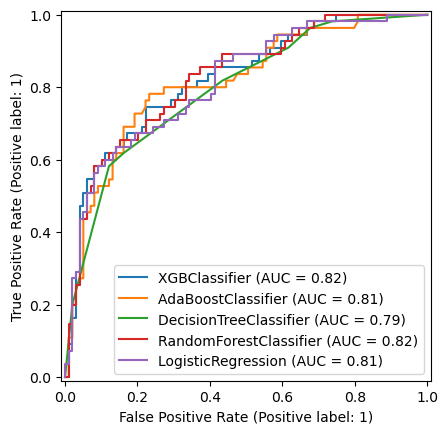

In [57]:
xgb_roc = RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)
ada_roc = RocCurveDisplay.from_estimator(ada_model, X_test, y_test, ax=xgb_roc.ax_)
dt_roc = RocCurveDisplay.from_estimator(dt_model, X_test, y_test, ax=xgb_roc.ax_)
rf_roc = RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=xgb_roc.ax_)
lr_roc = RocCurveDisplay.from_estimator(lr_model, X_test, y_test, ax=xgb_roc.ax_)



## SHAP value (Reminder)

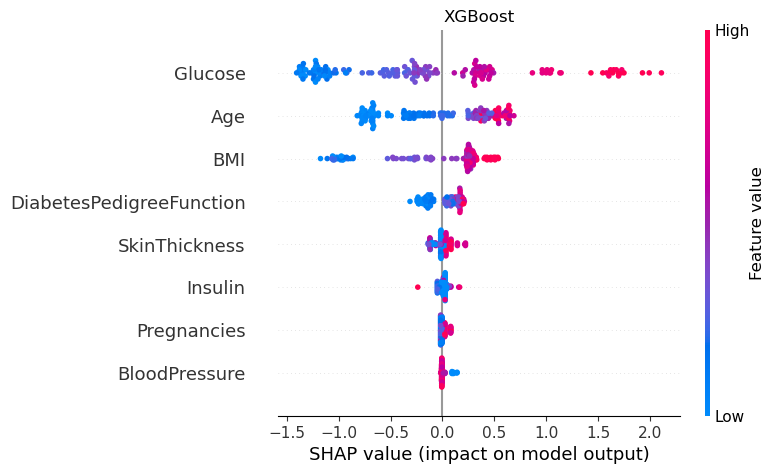

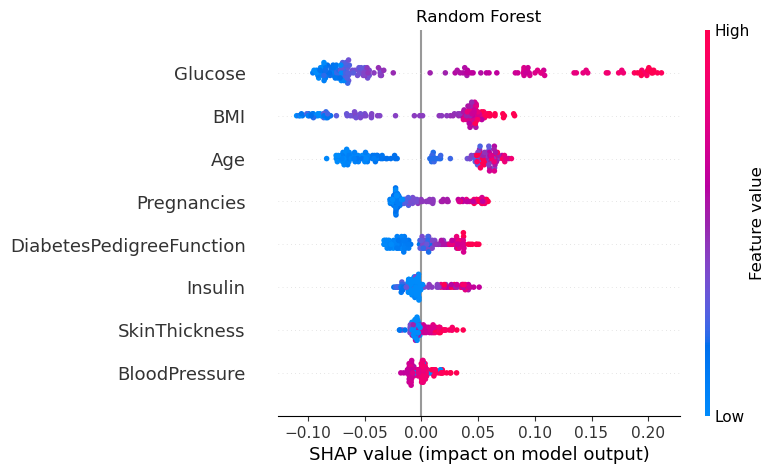

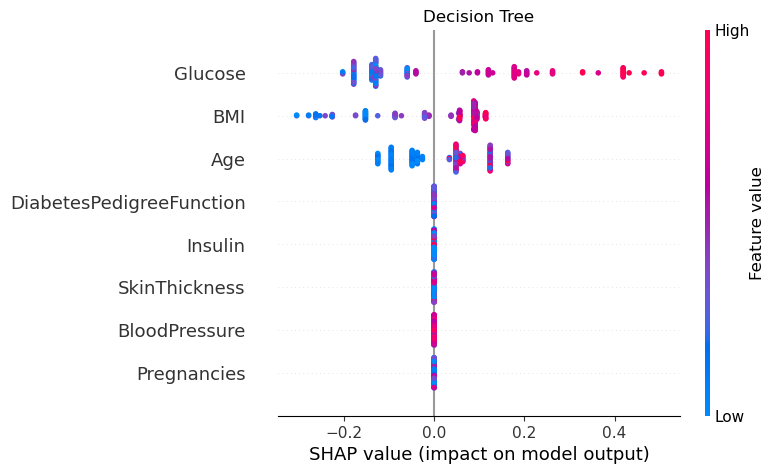

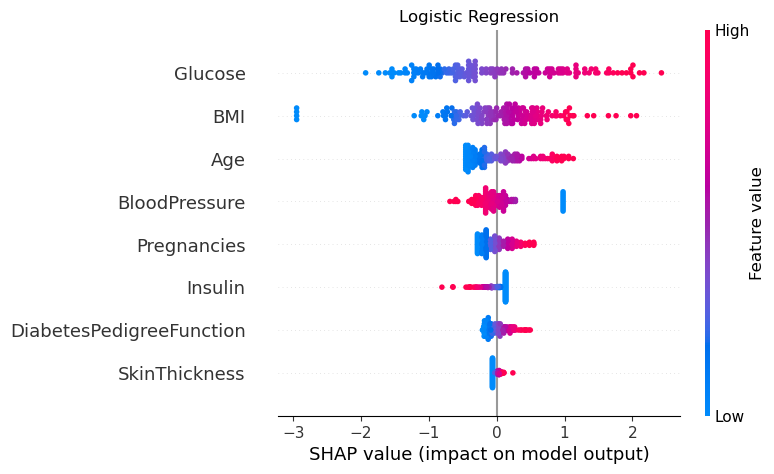

In [59]:
## XGBoost (OK)
#shap.initjs()
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test)
shap.summary_plot(xgb_shap_values, X_test, show=False)
plt.title("XGBoost")
plt.show()

## AdaBoost (CANNOT USE)
#ada_explainer = shap.TreeExplainer(ada_model)
#ada_shap_values = ada_explainer.shap_values(X_test)
#shap.summary_plot(ada_shap_values, X_test, show=False)
#plt.title("AdaBoost")
#plt.show()


## RandomForest (OK)
#shap.initjs()
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test)
shap.summary_plot(rf_shap_values[:,:,1], X_test, show=False)
plt.title("Random Forest")
plt.show()

## Decision Tree (OK)
dt_explainer = shap.TreeExplainer(dt_model)
dt_shap_values = dt_explainer.shap_values(X_test)
shap.summary_plot(dt_shap_values[:,:,1], X_test, show=False)
plt.title("Decision Tree")
plt.show()

## Logistic Regression (OK)
masker = shap.maskers.Independent(data=X_test)
lr_explainer = shap.LinearExplainer(lr_model, masker=masker)
lr_shap_values = lr_explainer.shap_values(X_test)
shap.summary_plot(lr_shap_values, X_test, show=False)
plt.title("Logistic Regression")
plt.show()

